# [IAFlash](https://entrepreneur-interet-general.etalab.gouv.fr/defis/2019/iaflash.html) simple exploration

## API skeleton

This is in essence what a client API whould run.  

**Important note**: this API only aims at classifying cars on preprocessed images. No work is done regarding e.g. object detection.

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/'))    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
# import re
# import pandas as pd
import time
import pickle
from PIL import Image

# from keras.preprocessing.image import ImageDataGenerator
# from keras.applications import densenet
from keras.models import load_model
# from keras.layers import Conv2D, MaxPooling2D
# from keras.layers import Activation, Dropout, Flatten, Dense
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
# from keras import regularizers
# from keras import backend as K

# from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

# from IAFlash.helpers import DataHandler, ImageWorker # needs correct working directory

Using TensorFlow backend.


### Variables

In [2]:
# data
if HOST == 'Arthurs-MacBook-Pro.local':
    pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwTrueresampleFilter0')
    pathToIntellDir = os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/')
else:
    raise ValueError('unknown host: {}'.format(HOST))

# intelligence
datagen = pickle.load(open(pathToIntellDir+'datagen.pkl','rb'))
classesDict = pickle.load(open(pathToIntellDir+'classesDict.pkl','rb'))
model = load_model(pathToIntellDir+'model.h5')
K = 5

# testing
# image_file = os.path.join(pathToDataDir, 'Test', 'Acura TL Type-S 2008/000290.jpg')
image_file = os.path.join(pathToDataDir, 'Test', 'Porsche Panamera Sedan 2012/014241.jpg')
# image_file = os.path.join(pathToDataDir, 'Test', 'Ford Ranger SuperCab 2011/009079.jpg')

# seed
seed = 8
np.random.seed(seed)

### Example of API call


top 5 predictions for image:


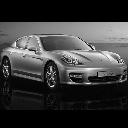

   Ford Edge SUV 2012 (0.01362711563706398)
   Audi TT Hatchback 2011 (0.01284023467451334)
   Dodge Caliber Wagon 2007 (0.012164943851530552)
   BMW X6 SUV 2012 (0.011722292751073837)
   Cadillac SRX SUV 2012 (0.011534429155290127)

all predictions:


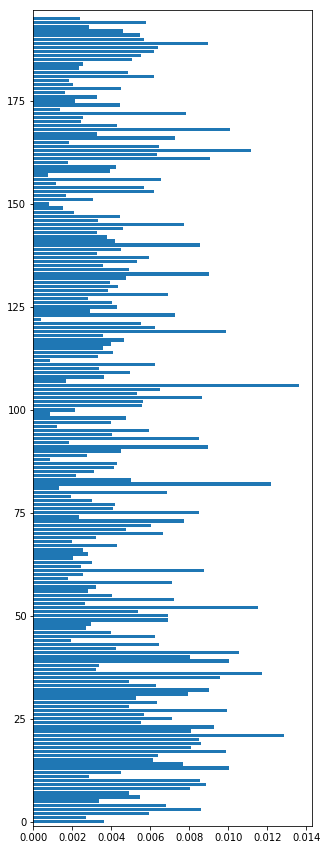

In [3]:
#-- load image and array
image = Image.open(image_file)

x = np.array(image)
if 'channels_last' == datagen.data_format:
    x = x.reshape((1, x.shape[0], x.shape[1], 1)) # [sample, w, h, channel]
else:
    raise ValueError('cannot work with othet data format than "channels_last".')
    
    
#-- run model
# NB: we use a (dummy) generator in order to
# take into account the processing done by `datagen`
generator = datagen.flow(x,
                         y=None,
                         batch_size=1,
                         shuffle=False,
                         seed=None,
#                          save_to_dir=pathToDataDir, # use this to print one batch when calling generator[batchIdx]
#                          save_prefix='valid_',      #
#                          save_format='png'          #
                         )

score = model.predict_generator(generator,
                                steps=len(generator),
                                max_queue_size=10,
                                workers=1,
                                use_multiprocessing=False,
                                verbose=0).flatten()
predicted = np.argmax(score)
argsort_score = np.argsort(score)[::-1]


#-- output
print('\ntop {} predictions for image:'.format(K))
display(image)
for k in range(K):
    iv = int(argsort_score[k]) # NB: does not work inside the list comprehension...
    label = [k for k,v in classesDict.items() if v == iv][0]
    print('   {} ({})'.format(label, score[argsort_score[k]]))
    
print('\nall predictions:')
f = plt.figure(figsize=(5,15))
ax = f.add_subplot(1,1,1)
ax.barh(np.arange(len(score)),
        score,
        height=0.8,
        left=None,
        align='center')
ax.set_ylim((-1,len(score)+1))
plt.show()